In [1]:
# !pip install SimpleITK
# !pip install monai
!pip install torchio
!pip install MedPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 5.3 MB/s 
     |████████████████████████████████| 48.4 MB 29 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 5.3 MB/s 
  Created wheel for MedPy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754463 sha256=b78cbefdb0e176c6844ccfb8b908f1ad0fa665de1e1b57a21530f69c734fdcf0
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built MedPy


In [ ]:
# !pip install synapseclient
# import synapseclient 
# import synapseutils 
# syn = synapseclient.Synapse() 
# syn.login('Snehaa27','27#Suave') 
# filesdata = synapseutils.syncFromSynapse(syn, entity='syn18824258', path='/content/drive/MyDrive/data')

In [ ]:
# import shutil
# import os

# p = '/content/drive/MyDrive/DLMIA/data/Challenge data/Test set/Images'
# for files in os.listdir(p):
#   if "CTAI" in files:
#     print(files)
#     shutil.move(os.path.join(p,files), "/content/drive/MyDrive/DLMIA/data/Challenge data/Test set/CTAI")

In [ ]:
# !ls '/content/drive/MyDrive/DLMIA/data/Challenge data/Training set/Reference standard' | wc -l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# devicess = [0]
import sys
sys.path.insert(0,'/content/drive/MyDrive/DLMIA/Colab Notebooks/Pytorch-Medical-Segmentation-master')

import time
import argparse
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torchvision import transforms
import torch.distributed as dist
import math
import torchio
from torchio.transforms import (ZNormalization,)
from tqdm import tqdm
from torchvision import utils
from hparam import hparams as hp
from utils.metric import metric
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR,CosineAnnealingLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from data_function import MedData_test
from data_function import MedData_train
from models.three_d.residual_unet3d import UNet

from loss_function import Binary_Loss,DiceLoss
from torch.nn.modules.loss import CrossEntropyLoss

from sklearn.utils import class_weight

# from focal_loss import FocalLoss

In [ ]:
class args_cls:
  def __init__(self):
    self.output_dir = hp.output_dir
    self.latest_checkpoint_file = hp.latest_checkpoint_file
    self.epochs = hp.total_epochs
    self.epochs_per_checkpoint = hp.epochs_per_checkpoint
    self.batch = hp.batch_size
    self.ckpt = hp.ckpt
    self.init_lr = hp.init_lr
    self.local_rank = 0
    self.seed = 0
    self.amp_run = None
    self.cudnn_enabled = True
    self.cudnn_benchmark = True
    self.disable_uniform_initialize_bn_weight = None

In [ ]:
source_train_dir = hp.source_train_dir
label_train_dir = hp.label_train_dir

source_test_dir = hp.source_test_dir
label_test_dir = hp.label_test_dir

output_dir_test = hp.output_dir_test

In [ ]:
# import torch
# import torch.nn as nn

# class FocalLoss(nn.modules.loss._WeightedLoss):
#     def __init__(self, weight=None, gamma=2, device='cpu'):
#         super(FocalLoss, self).__init__(weight)
#         # focusing hyper-parameter gamma
#         self.gamma = gamma

#         # class weights will act as the alpha parameter
#         self.weight = weight
        
#         # using deivce (cpu or gpu)
#         self.device = device
        
#         self.ce_loss = nn.CrossEntropyLoss()

#     def forward(self, _input, _target):
#         focal_loss = 0
#         print(_input[0].size()[-1])
#         print(_target.size())
        
#         print(type(_input))
#         print(type(_target))
#         for i in range(len(_input)):
#             # -log(pt)
            
#             cur_ce_loss = self.ce_loss(_input[i].view(-1, _input[i].size()[-1]), _target[i].view(-1))
#             # pt
#             pt = torch.exp(-cur_ce_loss)

#             if self.weight is not None:
#                 # alpha * (1-pt)^gamma * -log(pt)
#                 cur_focal_loss = self.weight[_target[i]] * ((1 - pt) ** self.gamma) * cur_ce_loss
#             else:
#                 # (1-pt)^gamma * -log(pt)
#                 cur_focal_loss = ((1 - pt) ** self.gamma) * cur_ce_loss
                
#             focal_loss = focal_loss + cur_focal_loss

#         if self.weight is not None:
#             focal_loss = focal_loss / self.weight.sum()
#             return focal_loss.to(self.device)
        
#         focal_loss = focal_loss / torch.tensor(len(probs))    
#         return focal_loss.to(self.device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs.squeeze().float(),  targets.squeeze().float())
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

In [ ]:
#Clip HU values 
#change the patch size
#Normalize the images


#check the loss functions

mean = -464.0940
std = 462.1842

def train():
    args = args_cls()
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = args.cudnn_enabled
    torch.backends.cudnn.benchmark = args.cudnn_benchmark
    os.makedirs(args.output_dir, exist_ok=True)

    model = UNet(in_channels=hp.in_class, n_classes=hp.out_class+1, base_n_filter=2)
    model = torch.nn.DataParallel(model, device_ids=None)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.init_lr)

    # scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.5, patience=20, verbose=True)
    scheduler = StepLR(optimizer, step_size=hp.scheduer_step_size, gamma=hp.scheduer_gamma)
    # scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=5e-6)

    if args.ckpt is not None:
        print("load model:", args.ckpt)
        print(os.path.join(args.output_dir, args.latest_checkpoint_file))
        ckpt = torch.load(os.path.join(args.output_dir, args.latest_checkpoint_file), map_location=lambda storage, loc: storage)

        model.load_state_dict(ckpt["model"])
        optimizer.load_state_dict(ckpt["optim"])

        for state in optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v#.cuda()

        # scheduler.load_state_dict(ckpt["scheduler"])
        elapsed_epochs = ckpt["epoch"]
    else:
        elapsed_epochs = 0

    model#.cuda()  #============================================uncomment this========================

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(sum(p.numel() for p in model.parameters()))
    print(total_params)

    class_weights=torch.tensor(np.array([0.5,2000]),dtype=torch.float)
    criterion_dice = DiceLoss(2)#.cuda() #======================================uncomment this=================
    criterion_ce = CrossEntropyLoss(weight=class_weights)#.cuda()  #======================================uncomment this=================
    criterion_focal = FocalLoss()

    writer = SummaryWriter(args.output_dir)

    train_dataset = MedData_train(source_train_dir,label_train_dir)
    # train_loader = DataLoader(train_dataset.queue_dataset, batch_size=args.batch, 
    #                           shuffle=True, pin_memory=True,drop_last=True)

    model.train()
    epochs = args.epochs - elapsed_epochs
    # iteration = elapsed_epochs * len(train_loader)

    #Training starts here
    #Loop through epochs
    for epoch in range(1, epochs + 1): 
        print("\nEpoch =============> "+str(epoch))
        epoch += elapsed_epochs
        num_iters = 0


        epoch_ce = []
        epoch_dice = []
        epoch_total = []
        #Loop through individual images
        for i,subj in enumerate(train_dataset.subjects):
          # print(subj['name'])
          # np_img = subj['source'][torchio.DATA].cpu().detach().numpy()
          # image_array = np.swapaxes(np_img, 0, 2) 
          # u, counts = np.unique(image_array, return_counts=True)
          # print(u,counts)

          # subj = znorm(subj)
          grid_sampler = torchio.inference.GridSampler(
                  subj,
                  hp.patch_size,
                  hp.patch_overlap,
              )

          patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=args.batch)
          # model.eval()


          total_loss_ce = []
          total_loss_dice = []
          #Loop through patches
          for patches_batch in tqdm(patch_loader):
                optimizer.zero_grad()
                x = patches_batch['source']['data']
                y = patches_batch['label']['data']
                # locations = patches_batch[torchio.LOCATION]



                if torch.all(x<130):
                  # print("All pixel below 130HU")
                  continue
                
                # print(y.size())
                y_back = torch.zeros_like(y)
                y_back[(y==0)]=1
                x = x.type(torch.FloatTensor)#.cuda()  #=====================uncomment this
                y = torch.cat((y_back, y),1) 
                y = y.type(torch.FloatTensor)#.cuda() #=====================uncomment this
                y[y!=0] = 1    

                key = 0
                np_img_target = y.cpu().detach().numpy()
                u, counts = np.unique(np_img_target[0][1], return_counts=True)
                if len(u)>10:
                  key=1
                  print("\nTarget unique counts:", u,counts)


                x = (x-mean)/std
                outputs = model(x)


                if key==1:
                  np_img_pred = outputs.argmax(dim=1).cpu().detach().numpy()
                  u, counts = np.unique(np_img_pred, return_counts=True)
                  print("Predicted unique counts:", u,counts)
                # print(outputs.size())
                # for metrics
                labels = outputs.argmax(dim=1)
                model_output_one_hot = torch.nn.functional.one_hot(labels, num_classes=hp.out_class+1).permute(0,4,1,2,3)
                l1 = criterion_ce(outputs, y.argmax(dim=1))
                l2 = criterion_dice(outputs.argmax(dim=1), y.argmax(dim=1))
                l3 = criterion_focal(outputs.argmax(dim=1), y.argmax(dim=1))
                # print(l3)
                # print(l2)
                # print(l1)

                loss =  l1 +l2+l3   #===================Change this to Weighted cross entropy
                # loss.requires_grad= True

                # logits = torch.sigmoid(outputs)
                # labels = logits.clone()
                # labels[labels>0.5] = 1
                # labels[labels<=0.5] = 0
                num_iters += 1
                loss.backward()
                optimizer.step()
                # iteration += 1
                # y_argmax = y.argmax(dim=1)
                # y_one_hot = torch.nn.functional.one_hot(y_argmax, num_classes=hp.out_class+1).permute(0,4,1,2,3)
    
                # false_positive_rate,false_negtive_rate,dice = metric(y_one_hot[:,1:,:,:].cpu(),model_output_one_hot[:,1:,:,:].cpu())
        
                # # false_positive_rate,false_negtive_rate,dice = metric(y.cpu(),labels.cpu())
                # ## log
                # writer.add_scalar('Training/false_positive_rate', false_positive_rate,iteration)
                # writer.add_scalar('Training/false_negtive_rate', false_negtive_rate,iteration)
                # writer.add_scalar('Training/dice', dice,iteration)
                

                total_loss_ce.append(l1)
                total_loss_dice.append(l2)


          epoch_ce.append(sum(total_loss_ce)/len(total_loss_ce))
          epoch_dice.append(sum(total_loss_dice)/len(total_loss_dice))
          final_loss = (sum(total_loss_ce)/len(total_loss_ce)) + (sum(total_loss_dice)/len(total_loss_dice))
          epoch_total.append(final_loss)

          with open (args.output_dir+'/results_detailed.txt', 'a+') as f:
            f.write('Training/CE_Loss '+ str(sum(total_loss_ce)/len(total_loss_ce))+' '+str(epoch)+'\n')
            f.write('Training/Dice_Loss '+ str(sum(total_loss_dice)/len(total_loss_dice))+' '+str(epoch)+'\n')

          # print("CE loss:", sum(total_loss_ce)/len(total_loss_ce))
          # print("DICE loss:", sum(total_loss_dice)/len(total_loss_dice))
          # print('lr:'+str(scheduler._last_lr[0]))
          # break

        avg_ce = sum(epoch_ce)/len(epoch_ce)
        avg_dice = sum(epoch_dice)/len(epoch_dice)
        avg_total = sum(epoch_total)/len(epoch_total)
        # writer.add_scalar('Training/CE_Loss', avg_ce.item(),epoch)
        # writer.add_scalar('Training/Dice_Loss', avg_dice.item(),epoch)
        # writer.add_scalar('Training/Total_Loss', avg_total.item(),epoch)

        with open (args.output_dir+'/results.txt', 'a+') as f:
          f.write('Training/CE_Loss '+ str(avg_ce)+' '+str(epoch)+'\n')
          f.write('Training/Dice_Loss '+ str(avg_dice)+' '+str(epoch)+'\n')
          f.write('Training/Total_Loss '+ str(avg_total)+' '+str(epoch)+'\n')

        print('CE_Loss:',avg_ce.item())
        print('Dice_Loss:',avg_dice.item())
        print('Total_Loss:',avg_total.item())
        scheduler.step()


        # Store latest checkpoint in each epoch
        torch.save(
            {
                "model": model.state_dict(),
                "optim": optimizer.state_dict(),
                "scheduler":scheduler.state_dict(),
                "epoch": epoch,

            },
            os.path.join(args.output_dir, args.latest_checkpoint_file),
        )


        # Save checkpoint
        if epoch % args.epochs_per_checkpoint == 0: #

            torch.save(
                {"model": model.state_dict(),"optim": optimizer.state_dict(),"epoch": epoch,},
                os.path.join(args.output_dir, f"checkpoint_{epoch:04d}.pt"),
            )
      
            with torch.no_grad():                  
                x = x[0].cpu().detach().numpy()
                y = y[0].cpu().detach().numpy()
                outputs = outputs[0].cpu().detach().numpy()
                model_output_one_hot = model_output_one_hot[0].float().cpu().detach().numpy()
                # affine = batch['source']['affine'][0].numpy()


                y = np.expand_dims(y, axis=1)
                outputs = np.expand_dims(outputs, axis=1)
                model_output_one_hot = np.expand_dims(model_output_one_hot, axis=1)

                # source_image = torchio.ScalarImage(tensor=x, affine=affine)
                # source_image.save(os.path.join(args.output_dir,f"step-{epoch:04d}-source"+hp.save_arch))
                # # source_image.save(os.path.join(args.output_dir,("step-{}-source.mhd").format(epoch)))

                # label_image = torchio.ScalarImage(tensor=y[1], affine=affine)
                # label_image.save(os.path.join(args.output_dir,f"step-{epoch:04d}-gt"+hp.save_arch))

                # output_image = torchio.ScalarImage(tensor=model_output_one_hot[1], affine=affine)
                # output_image.save(os.path.join(args.output_dir,f"step-{epoch:04d}-predict"+hp.save_arch))
         
    writer.close()

In [ ]:
train()

load model: /content/drive/MyDrive/DLMIA/Colab Notebooks/Pytorch-Medical-Segmentation-master/logs/checkpoint_latest.pt
/content/drive/MyDrive/DLMIA/Colab Notebooks/Pytorch-Medical-Segmentation-master/logs/checkpoint_latest.pt
111414
111414


KeyboardInterrupt: ignored

In [ ]:
# np_img_x = np.random.randint(2,size=(1,2,32, 32,32))
# np_img_y = np.random.randint(2,size=(1,2,32, 32,32))

# np_img_x  = np_img_x.astype(float)
# np_img_y  = np_img_y.astype(float)
# t_x = torch.from_numpy(np_img_x)
# t_y = torch.from_numpy(np_img_y).argmax(dim=1)

# print(t_y[0].numpy())
# # print(np_img_x)
# print(t_y.size())
# class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(t_y), y=t_y[0].numpy())
# class_weights=torch.tensor(np.array([0.9,0.1]),dtype=torch.double)
# cce = CrossEntropyLoss(weight = class_weights )
# ll1 = cce(t_x,t_y)
# print(ll1)

In [ ]:
# import torch

# from sklearn.utils import class_weight

# x = torch.randn(20, 5) 

# y = torch.randint(0, 5, (20,)) # classes

# print(x)
# print(y)
# class_weights=class_weight.compute_class_weight(

#                                         class_weight = "balanced",

#                                         classes = np.unique(y),

#                                         y = y.numpy()                                                    

#                                     )

# class_weights=torch.tensor(class_weights,dtype=torch.float)

# #Another sample calculation for weight :
# # nSamples = [887, 6130, 480, 317, 972, 101, 128] 
# # normedWeights = [1 - (x / sum(nSamples)) for x in nSamples] 
# # normedWeights = torch.FloatTensor(normedWeights).to(device)

# print(class_weights)

In [ ]:
from pathlib import Path
import torchio as tio
from torchio.transforms import (
    RandomFlip,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomMotion,
    RandomBiasField,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
    HistogramStandardization,
    OneOf,
    Compose,
    Clamp
)

class MedData_test_new(torch.utils.data.Dataset):
    def __init__(self, images_dir):


        self.subjects = []

        if (hp.in_class == 1) and (hp.out_class == 1) :

            images_dir = Path(images_dir)
            self.image_paths = sorted(images_dir.glob(hp.fold_arch))
            # labels_dir = Path(labels_dir)
            # self.label_paths = sorted(labels_dir.glob(hp.fold_arch))

            for image_path in self.image_paths:
                subject = tio.Subject(
                    source=tio.ScalarImage(image_path),
                    name = str(image_path)
                )
                self.subjects.append(subject)
        

        self.transforms = self.transform()

        self.training_set = tio.SubjectsDataset(self.subjects, transform=None)

    def transform(self):
        training_transform = Compose([
        CropOrPad((hp.crop_or_pad_size), padding_mode='reflect'),
        # ZNormalization(),
        ])


In [ ]:
mean = -464.0940
std = 462.1842
def test():
    output_dir_test = '/content/drive/MyDrive/Colab Notebooks/Pytorch-Medical-Segmentation-master/output_results'
    args = args_cls()

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = args.cudnn_enabled
    torch.backends.cudnn.benchmark = args.cudnn_benchmark

    from data_function import MedData_test
    os.makedirs(output_dir_test, exist_ok=True)

    #from models.three_d.unet3d import UNet3D
    #model = UNet3D(in_channels=hp.in_class, out_channels=hp.out_class+1, init_features=32)

    from models.three_d.residual_unet3d import UNet
    model = UNet(in_channels=hp.in_class, n_classes=hp.out_class+1, base_n_filter=2)


    model = torch.nn.DataParallel(model, device_ids=None)


    print("load model:", '/content/drive/MyDrive/DLMIA/Colab Notebooks/Pytorch-Medical-Segmentation-master/logs/checkpoint_latest.pt') #args.ckpt
    print(os.path.join(args.output_dir, args.latest_checkpoint_file))
    ckpt = torch.load(os.path.join(args.output_dir, args.latest_checkpoint_file), map_location=lambda storage, loc: storage)

    model.load_state_dict(ckpt["model"])
    # model.cuda()


    test_dataset = MedData_test_new(source_train_dir)
    # znorm = ZNormalization()

    if hp.mode == '3d':
        patch_overlap = hp.patch_overlap
        patch_size = hp.patch_size
    elif hp.mode == '2d':
        patch_overlap = hp.patch_overlap
        patch_size = hp.patch_size


    for i,subj in enumerate(test_dataset.subjects):
        if i<=6:
          continue
        # print(type(subj))
        # print(subj['name'])
        # print(subj['source'][tio.DATA])
        namee = subj['name'].split("/")[-1]
        # subj = znorm(subj)
        grid_sampler = torchio.inference.GridSampler(
                subj,
                patch_size,
                patch_overlap,
            )

        patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=args.batch)
        # aggregator = torchio.inference.GridAggregator(grid_sampler)
        aggregator_1 = torchio.inference.GridAggregator(grid_sampler)
        model.eval()
        with torch.no_grad():
            for patches_batch in tqdm(patch_loader):
                input_tensor = patches_batch['source'][torchio.DATA].to(device)
                locations = patches_batch[torchio.LOCATION]


                if torch.all(input_tensor<130):
                  aggregator_1.add_batch(torch.zeros(1, 1, 128, 128, 32), locations)
                else:
                    # outputs = model(input_tensor)
                    input_tensor = (input_tensor-mean)/std
                    outputs = model(input_tensor)
                    # print(outputs)
                    labels = outputs.argmax(dim=1)
                    # model_output_one_hot = torch.nn.functional.one_hot(labels, num_classes=hp.out_class+1).permute(0,4,1,2,3)
                    # logits = torch.sigmoid(outputs)

                    # labels = logits.clone()
                    # labels[labels>0.5] = 1
                    # labels[labels<=0.5] = 0

                    # aggregator.add_batch(model_output_one_hot, locations)
                    aggregator_1.add_batch(labels.unsqueeze(1), locations)
        # output_tensor = aggregator.get_output_tensor()
        output_tensor_1 = aggregator_1.get_output_tensor()
        print(output_tensor_1)



        affine = subj['source']['affine']
        # label_image = torchio.ScalarImage(tensor=output_tensor.numpy(), affine=affine)
        # label_image.save(os.path.join(output_dir_test,f"{i:04d}-result_float"+hp.save_arch))

        # f"{str(i):04d}-result_float.mhd"
        print('saving image'+'/content/drive/MyDrive/DLMIA/Colab Notebooks/Pytorch-Medical-Segmentation-master/output_results'+namee)
        output_image = torchio.ScalarImage(tensor=output_tensor_1.numpy(), affine=affine)
        output_image.save('/content/drive/MyDrive/DLMIA/Colab Notebooks/Pytorch-Medical-Segmentation-master/output_results/'+namee.split('.')[0][:-3]+"S.mhd")
        # return output_tensor_1.numpy()


In [ ]:
test()

load model: /content/drive/MyDrive/DLMIA/Colab Notebooks/Pytorch-Medical-Segmentation-master/logs/checkpoint_latest.pt
/content/drive/MyDrive/DLMIA/Colab Notebooks/Pytorch-Medical-Segmentation-master/logs/checkpoint_latest.pt


100%|██████████| 147/147 [00:58<00:00,  2.50it/s]
/usr/local/lib/python3.7/dist-packages/torchio/data/inference/aggregator.py:171: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)


tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 

 26%|██▌       | 25/98 [00:11<00:32,  2.22it/s]


KeyboardInterrupt: ignored

In [ ]:
img.shape

(1, 512, 512, 64)

In [ ]:
# !pip install SimpleITK
import SimpleITK as sitk
import numpy as np
def describe(path):
  image_file = path
  # print("====Image info====")
  with open(image_file) as f: 
      for line in f: 
          # print(line.strip()) 
          pass
  image = sitk.ReadImage(image_file)

  # print()
  print("image size:", image.GetSize()) 
  # print("image origin:",image.GetOrigin()) 
  # print("image spacing:",image.GetSpacing()) 
  # print("image direction:",image.GetDirection()) 
  image_array = sitk.GetArrayFromImage(image) 
  image_array = np.swapaxes(image_array, 0, 2) 
  spacing = image.GetSpacing()
  voxel_volume = 0.001*np.prod(spacing) 
  # print('Volume is {} ml'.format(voxel_volume)) 
  size = image.GetSize() 
  # print('Full CT volume is {} l'.format(np.prod(size)*voxel_volume*0.001)) 
  # print()
  u, counts = np.unique(image_array, return_counts=True)
  # print('unique values:',u, indices)

  return u,counts,image.GetSize()[-1],image_array

counts,_,_,image_array = describe('/content/drive/MyDrive/DLMIA/Colab Notebooks/Pytorch-Medical-Segmentation-master/output_results/TRV2P6S.mhd')

image size: (512, 512, 47)


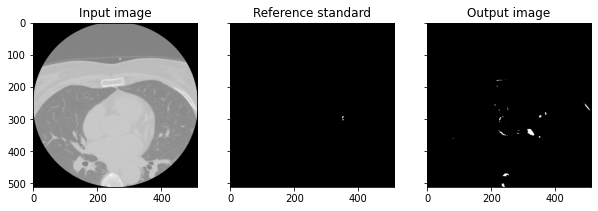

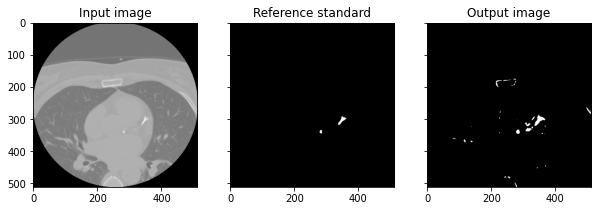

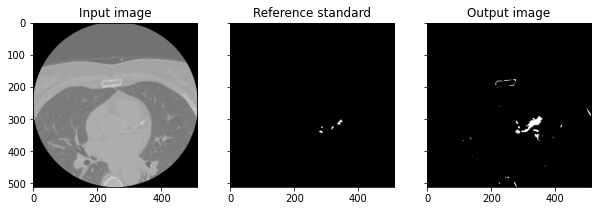

In [ ]:
_ref_std = sitk.ReadImage('/content/drive/MyDrive/DLMIA/data/Challenge data/Training set/Reference standard/TRV1P7R.mhd')
ref_std = sitk.GetArrayFromImage(_ref_std) 
ref_std = np.swapaxes(ref_std, 0, 2) 

_pred = sitk.ReadImage('/content/drive/MyDrive/DLMIA/Colab Notebooks/Pytorch-Medical-Segmentation-master/output_results/TRV1P7S.mhd')
pred = sitk.GetArrayFromImage(_pred) 
pred = np.swapaxes(pred, 0, 2) 

_img = sitk.ReadImage('/content/drive/MyDrive/DLMIA/data/Challenge data/Training set/Images/TRV1P7CTI.mhd')
img = sitk.GetArrayFromImage(_img) 
img = np.swapaxes(img, 0, 2) 

import matplotlib.pyplot as plt
for x in range (45,48):
  # plt.figure()  
  # plt.imshow(img[0][:,:, x].transpose(),cmap='gray') #, vmin=-300, vmax=450 
  # plt.show()

  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(10,10))
  ax1.imshow(img[:,:, x].transpose(),cmap='gray')
  ax1.set_title('Input image')
  ax2.imshow(ref_std[:,:, x].transpose(),cmap='gray')
  ax2.set_title('Reference standard')
  ax3.imshow(pred[:,:, x].transpose(),cmap='gray')
  ax3.set_title('Output image')


In [ ]:
!ls '/content/drive/MyDrive/data/Challenge data/Training set/Images' | wc -l

In [ ]:
!ls '/content/drive/MyDrive/data/Challenge data/Test set/Images' | wc -l

80


In [ ]:
import shutil
import os

p = '/content/drive/MyDrive/data/Challenge data/Test set/Images'
for files in os.listdir(p):
  if "CTAI" in files:
    print(files)
    shutil.move(os.path.join(p,files), "/content/drive/MyDrive/data/Challenge data/Test set/CTAI")

In [ ]:
from sklearn.metrics import f1_score
def test2():
    # parser = argparse.ArgumentParser(description='PyTorch Medical Segmentation Testing')
    # parser = parse_training_args(parser)
    # args, _ = parser.parse_known_args()
    source_test_dir = '/content/drive/MyDrive/data/Challenge data/Training set/Images'
    label_test_dir = '/content/drive/MyDrive/data/Challenge data/Training set/Reference standard'
    args = args_cls()

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = args.cudnn_enabled
    torch.backends.cudnn.benchmark = args.cudnn_benchmark

    from data_function import MedData_test
    os.makedirs(output_dir_test, exist_ok=True)

    from models.three_d.residual_unet3d import UNet
    model = UNet(in_channels=hp.in_class, n_classes=hp.out_class+1, base_n_filter=2)


    model = torch.nn.DataParallel(model, device_ids=None)


    print("load model:", '/content/drive/MyDrive/Colab Notebooks/Pytorch-Medical-Segmentation-master/logs/checkpoint_latest.pt')#args.ckpt
    print(os.path.join(args.output_dir, args.latest_checkpoint_file))
    ckpt = torch.load(os.path.join(args.output_dir, args.latest_checkpoint_file), map_location=lambda storage, loc: storage)

    model.load_state_dict(ckpt["model"])
    # model.cuda()

    test_dataset = MedData_test(source_test_dir,label_test_dir)
    # znorm = ZNormalization()

    patch_overlap = hp.patch_overlap
    patch_size = hp.patch_size



    for i,subj in enumerate(test_dataset.subjects):
        # subj = znorm(subj)
        grid_sampler = torchio.inference.GridSampler(
                subj,
                patch_size,
                patch_overlap,
            )

        patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=args.batch)
        # aggregator = torchio.inference.GridAggregator(grid_sampler)
        aggregator_1 = torchio.inference.GridAggregator(grid_sampler)
        model.eval()
        with torch.no_grad():
            for patches_batch in tqdm(patch_loader):


                input_tensor = patches_batch['source'][torchio.DATA].to(device)
                input_tensor = input_tensor.type(torch.FloatTensor)
                locations = patches_batch[torchio.LOCATION]
                if torch.all(input_tensor<130):
                  aggregator_1.add_batch(torch.zeros(1, 1, 32, 32, 32), locations)
                else:
                    labels = model(input_tensor)

                    # print(outputs)
                    # labels = outputs.argmax(dim=1)
                    print(labels.shape)
                    # print(labels.unsqueeze(1).shape)
                    # model_output_one_hot = torch.nn.functional.one_hot(labels, num_classes=hp.out_class+1).permute(0,4,1,2,3)
                    # logits = torch.sigmoid(outputs)

                    # labels = logits.clone()
                    # labels[labels>0.5] = 1
                    # labels[labels<=0.5] = 0

                    # aggregator.add_batch(model_output_one_hot, locations)
                    aggregator_1.add_batch(labels, locations)
        # output_tensor = aggregator.get_output_tensor()

        


        output_tensor_1 = aggregator_1.get_output_tensor()
        print(output_tensor_1.cpu().detach().numpy().shape)
        print(subj['label'][torchio.DATA].to(device).cpu().detach().numpy().shape)
        y_pred = output_tensor_1.cpu().detach().numpy().ravel()
        y_true = subj['label'][torchio.DATA].to(device).cpu().detach().numpy().ravel()
        u, indices = np.unique(y_pred, return_inverse=True)
        print('unique values:',u, indices)
        print(y_pred.shape)
        print(f1_score(y_true, y_pred, average='macro'))


        affine = subj['source']['affine']
        # label_image = torchio.ScalarImage(tensor=output_tensor.numpy(), affine=affine)
        # label_image.save(os.path.join(output_dir_test,f"{i:04d}-result_float"+hp.save_arch))

        # f"{str(i):04d}-result_float.mhd"

        output_image = torchio.ScalarImage(tensor=output_tensor_1.numpy(), affine=affine)
        # output_image.save(os.path.join(output_dir_test,f"{i:04d}-result_int"+hp.save_arch))
         


In [ ]:
test2()

load model: /content/drive/MyDrive/Colab Notebooks/Pytorch-Medical-Segmentation-master/logs/checkpoint_latest.pt
/content/drive/MyDrive/Colab Notebooks/Pytorch-Medical-Segmentation-master/logs/checkpoint_latest.pt


  1%|▏         | 15/1083 [00:00<00:38, 27.49it/s]

torch.Size([1, 2, 32, 32, 32])


RuntimeError: ignored